In [1]:
from model_building import build_model
import keras_tuner
import pandas as pd
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.utils import img_to_array, load_img
import numpy as np
import random

Variablen definieren:

In [2]:
path = '../data/raw/'
filenames = os.listdir(path)
filenames.remove('.gitkeep')
image_size = (150, 150)
val_split = 0.1
test_split = 0.1
batch_size = 64

Funktionen für die Bildverarbeitung und dem Laden der Daten:

In [3]:
def get_label(string):
    """Returns the file name of `string` without parent dirs or suffix."""
    string  = ' '.join(string.split('/')[-1].replace('.png', '').split(' ')[0:-1])
    return string


In [4]:
def preprocessing(path, image_size, batch_size, val_split, test_split):
    """
    Setup training-, validation- and testdata generators.

    Reads data, assigns labels and performs data split before setting up the
    generators.

    Parameters
    ----------
    path : str
        Path to directory that contains the image files.
    image_size : tuple
        Size of the images (after resizing by the data generator, needs to be
        the same in the model).
    batch_size : int
        Batch size used by generators.
    val_split : float
        Specified ratio of validation data taken from the entire data set.
    test_split : float
        Specified ratio of test data taken from the entire data set.

    Returns
    -------
    train_generator, validation_generator, test_generator
    """
    # build dataframe with paths of images and labels
    filenames = os.listdir(path)
    filenames.remove('.gitkeep')
    df = pd.DataFrame(filenames, columns=['Filenames'])
    df['Label'] = df['Filenames'].apply(lambda x: get_label(x))

    # shuffle data and split (train, val, test)
    images_total = df.shape[0]
    val_size = int(images_total * val_split)
    test_size = int(images_total * test_split)

    df_val = df.sample(val_size, random_state=42)
    df = df.drop(df_val.index)

    df_test = df.sample(test_size, random_state=42)
    df = df.drop(df_test.index)
    df_train = df
    
    # setup data generators
    datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    train_generator = datagen_train.flow_from_dataframe(df_train,
                                              directory=path,
                                              x_col='Filenames',
                                              y_col='Label',
                                              target_size=image_size,
                                              batch_size= batch_size,
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              )
    datagen_val = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)                                          
    validation_generator = datagen_val.flow_from_dataframe(df_val,
                                              directory=path,
                                              x_col='Filenames',
                                              y_col='Label',
                                              target_size=image_size,
                                              batch_size=batch_size,
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              )

    datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
    test_generator = datagen_test.flow_from_dataframe(df_test,
                                              directory=path,
                                              x_col='Filenames',
                                              y_col='Label',
                                              target_size=image_size,
                                              batch_size=batch_size,
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              shuffle=False)
    
    return train_generator, validation_generator, test_generator

Preprocessing ausführen:

In [5]:
train_generator, validation_generator, test_generator = preprocessing(path, image_size,batch_size, val_split, test_split)

Found 32000 validated image filenames belonging to 50 classes.
Found 4000 validated image filenames belonging to 50 classes.
Found 4000 validated image filenames belonging to 50 classes.


Random Beispielbild anzeigen:

Sample image:


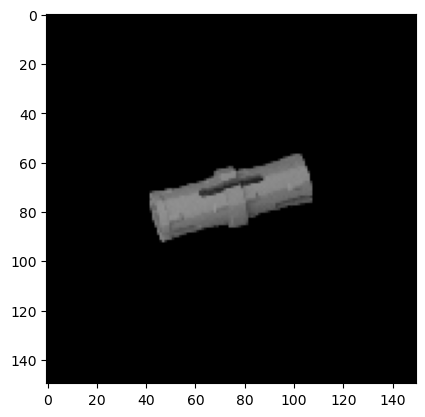

In [6]:
print("Sample image:")
img_files = [os.path.join(path, f) for f in filenames]
img_path = random.choice(img_files)
img = load_img(img_path, target_size=image_size)
plt.imshow(img)
plt.show()

## Hyperparameter Tuning 
Der Tuner wählt Hyperparameter und verwendet diese um verschiedene Modele zu bauen. Jedes Model wird trainiert und seine Performance bewertet. Das Model mit der besten Performance – und damit mit den besten Hyperparametern – wird abgespeichert.
Das Hyperparametergitter wird in mehreren Schritt verfeinert. Als Ausgangspunkt dienen die Hyperparameter des Baseline-Models.

In [7]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory="../experiments",
    project_name="Hyperparametertuning",
)

# run tuner
# The parameters passed to search() are the same as passed to model.fit()
tuner.search(train_generator,
             validation_data = validation_generator,
             epochs = 3,
             steps_per_epoch = None,
             validation_steps= 2
            )
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save(f"../models/saved_model")

Trial 5 Complete [00h 03m 01s]
val_accuracy: 0.5234375

Best val_accuracy So Far: 0.65625
Total elapsed time: 00h 15m 24s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Assets written to: ../models/saved_model\assets


INFO:tensorflow:Assets written to: ../models/saved_model\assets


## Retraining
Now the best model found during hyperparameter tuning is trained extensively.
The model is cloned to start with randomly initiated weights.

> Note
> 
> Due to problems loading the model saved by the tuner it is recreated here manually.

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64,2, activation="relu", input_shape=(150,150,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(56, 2, activation="relu"),
    tf.keras.layers.Conv2D(64, 2, activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=80, activation="relu"),
    tf.keras.layers.Dense(units=90, activation="relu"),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Dense(50, activation="softmax"),
])

In [40]:
#model_name = "saved_model"
#model = tf.keras.models.load_model("../models/" + model_name)
#clone = tf.keras.models.clone_model(model) # copy model with reset weights
model.compile(
       optimizer = "adam",
       loss = "categorical_crossentropy",
       metrics = "accuracy"
   )
history = model.fit(train_generator, validation_data=validation_generator, epochs=20, steps_per_epoch=None, validation_steps=30) 

Epoch 1/20
500/500 [==============================] - 90s 164ms/step - loss: 2.4187 - accuracy: 0.2769 - val_loss: 1.7383 - val_accuracy: 0.4333
Epoch 2/20
500/500 [==============================] - 70s 139ms/step - loss: 1.6682 - accuracy: 0.4535 - val_loss: 1.4903 - val_accuracy: 0.4984
Epoch 3/20
500/500 [==============================] - 69s 138ms/step - loss: 1.3079 - accuracy: 0.5589 - val_loss: 1.2786 - val_accuracy: 0.5813
Epoch 4/20
500/500 [==============================] - 68s 135ms/step - loss: 1.0401 - accuracy: 0.6413 - val_loss: 1.0682 - val_accuracy: 0.6276
Epoch 5/20
500/500 [==============================] - 68s 136ms/step - loss: 0.8303 - accuracy: 0.7075 - val_loss: 1.1441 - val_accuracy: 0.6266
Epoch 6/20
500/500 [==============================] - 70s 140ms/step - loss: 0.6685 - accuracy: 0.7577 - val_loss: 1.0789 - val_accuracy: 0.6542
Epoch 7/20
500/500 [==============================] - 68s 135ms/step - loss: 0.5436 - accuracy: 0.8041 - val_loss: 1.1676 - val_ac

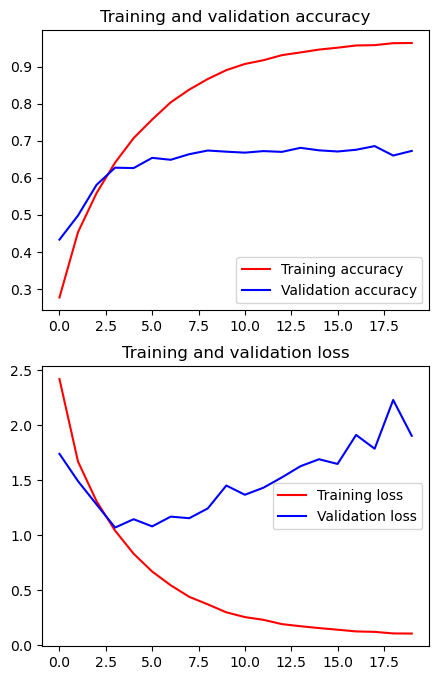

In [41]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize=(5,8))
fig.add_subplot(211)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

fig.add_subplot(212)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [79]:
model.evaluate(test_generator, verbose=0)

[1.984946846961975, 0.6685000061988831]

In [43]:
model.save(f"../models/66%.h5")

## Test Model on real Images

In [160]:
model= tf.keras.models.load_model("../models/66%.h5")

In [161]:

from PIL import Image, ImageOps
import numpy as np
from skimage import transform

def load(filename):
   """Load grayscaled image from specified path."""
   image = Image.open(filename).convert("L")
   image = ImageOps.fit(image,(150,150))
   return image

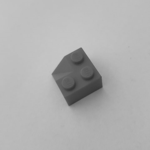

In [173]:
image_name = "Dach_2.png"
image = load('../data/external/' + image_name)
image

In [174]:
# prepare image to fit model input
image = np.array(image)
image = image.reshape((150, 150, 1))
image = image/255
image = np.expand_dims(image, axis=0)

# predict image
prediction = model.predict(image, verbose=0)
index_class_predicted = np.argmax(prediction)
keys=list(validation_generator.class_indices.keys())
class_predicted = keys[index_class_predicted]
class_predicted

'3001 brick 2x4'

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 149, 149, 64)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 73, 73, 56)        14392     
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        14400     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 82944)            